# NFL Match Data - Scoring Team Skill Using ELO

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
from tqdm.auto import tqdm

In [86]:
from elo_handling import elo_match_handler

In [91]:
df = pd.read_csv("Data/processed_game_history.csv", dtype={"ModifiedWeek": int}, parse_dates=["Date"])
df = df.drop(["Unnamed: 0", "AtHome"], axis=1)

In [92]:
df = df.sort_values(by="Date", ascending=True)

In [93]:
# ELO Config
k = 20
beta = 1000
start_score = 1500.0
seasons = df["Season"].unique()

In [106]:
base_elo_df = pd.DataFrame(columns=["Season", "Week", "Date", "Team", "Score"])
base_elo_df["Score"] = base_elo_df["Score"].astype(float)

for season in seasons:
    season_df = df[df["Season"] == season]
    start_date = season_df["Date"].min()
    teams = list(set(list(season_df["Winner/tie"].unique()) + list(season_df["Loser/tie"].unique())))
    for team in teams:
        new_row = {"Season": season, "Week": 0, "Date": start_date, "Team": team, "Score": start_score}
        base_elo_df = base_elo_df.append(new_row, ignore_index=True)

In [108]:
elo_df = base_elo_df.copy()
most_recent = {}

for index, row in tqdm(df.iterrows()):
    game_season = row["Season"]
    game_week = row["ModifiedWeek"]
    game_date = row["Date"]
    team_a = row["Winner/tie"]
    team_b = row["Loser/tie"]
    team_a_score = row["PtsW"]
    team_b_score = row["PtsL"]
    team_a_str = f"{game_season}_{team_a}"
    team_b_str = f"{game_season}_{team_b}"
    
    if team_a_str not in most_recent:
        most_recent[f"{game_season}_{team_a}"] = start_score
    if team_b_str not in most_recent:
        most_recent[f"{game_season}_{team_b}"] = start_score
    if game_week == 1:
        team_a_elo = start_score
        team_b_elo = start_score
    else:
        team_a_elo = most_recent.get(team_a_str, start_score)
        team_b_elo = most_recent.get(team_b_str, start_score)
        
    elo_obj = elo_match_handler(team_a_elo, team_b_elo, team_a_score, team_b_score, k, beta)
    newscore_a, newscore_b = elo_obj.get_updated_scores()
    most_recent[team_a_str] = newscore_a
    most_recent[team_b_str] = newscore_b
            
    elo_df = elo_df.append({"Season": game_season, "Week": game_week, "Date": game_date, "Team": team_a, "Score": newscore_a},
                           ignore_index=True)
    elo_df = elo_df.append({"Season": game_season, "Week": game_week, "Date": game_date, "Team": team_b, "Score": newscore_b},
                           ignore_index=True)

In [109]:
season_2020 = elo_df[elo_df["Season"] == 2020]
#season_2020["Score"] = season_2020["Score"].astype(float)

In [71]:
#season_2020["Week"] = pd.to_numeric(season_2020["Week"], errors="coerce")

/Users/alessiomorteo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


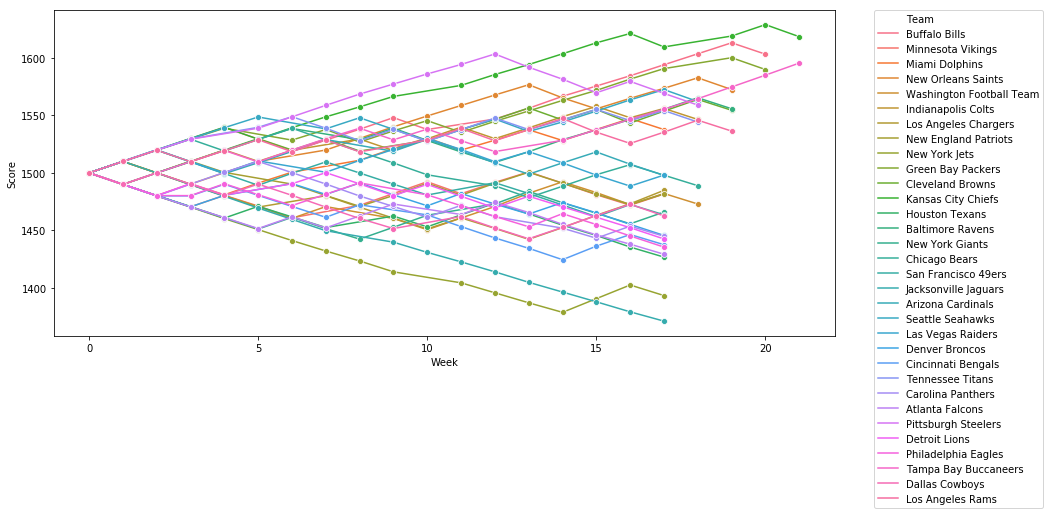

In [111]:
plt.subplots(figsize=(14, 6))
sns.lineplot(data=season_2020, x="Week", y="Score", hue="Team", marker="o")
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
for season in tqdm(seasons):
    season_df = df[df["Season"] == season]
    #season_elo_df = elo_df[elo_df["Season"] == season]
    #weeks = season_df["ModifiedWeek"].unique()
    for index, row in season_df.iterrows():
        game_week = row["Week"]
        game_date = row["Date"]
        team_a, team_b = row["Winner/tie"], row["Loser/tie"]
        team_a_score, team_b_score = row["PtsW"], row["PtsL"]
        team_a_elo = most_recent.get(team_a, start_score)
        team_b_elo = most_recent.get(team_b, start_score)
            
        elo_obj = elo_match_handler(team_a_elo, team_b_elo, team_a_score, team_b_score, k, beta)
        newscore_a, newscore_b = elo_obj.get_updated_scores()
        most_recent[team_a] = newscore_a
        most_recent[team_b] = newscore_b
            
        elo_df = elo_df.append({"Season": season, "Week": game_week, "Date": game_date, "Team": team_a, "Score": newscore_a},
                               ignore_index=True)
        elo_df = elo_df.append({"Season": season, "Week": game_week, "Date": game_date, "Team": team_b, "Score": newscore_b},
                               ignore_index=True)

In [8]:
for week in weeks:
        week_df = season_df[season_df["ModifiedWeek"] == week]
        week_elo_df = season_elo_df[season_elo_df["Week"] == week]
        for index, row in season_df.iterrows():
            team_a, team_b = row["Winner/tie"], row["Loser/tie"]
            team_a_score, team_b_score = row["PtsW"], row["PtsL"]
            team_a_elo = most_recent.get(team_a, start_score)
            team_b_elo = most_recent.get(team_b, start_score)
            
            elo_obj = elo_match_handler(team_a_elo, team_b_elo, team_a_score, team_b_score, k, beta)
            newscore_a, newscore_b = elo_obj.get_updated_scores()
            most_recent[team_a] = newscore_a
            most_recent[team_b] = newscore_b
            
            elo_df = elo_df.append({"Season": season, "Week": week, "Date": row["Date"], "Team": team_a, "Score": newscore_a},
                                   ignore_index=True)
            elo_df = elo_df.append({"Season": season, "Week": week, "Date": row["Date"], "Team": team_b, "Score": newscore_b},
                                   ignore_index=True)

AttributeError: 'dict' object has no attribute 'append'